### Initialize notebook

In [45]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
# Torch imports

import os
import sys
sys.path.append('/home/ak/PycharmProjects/ature')
os.chdir('/home/ak/PycharmProjects/ature')

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import PIL.Image as IMG
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import classification_report
from neuralnet.utils.weights_utils import initialize_weights

import matplotlib.pyplot as plt
import numpy as np

from commons.segmentation import AtureTest
from commons.IMAGE import SegmentedImage


from utils import img_utils as imgutil
from commons.IMAGE import Image
from neuralnet.hybridnet.hybridnet_trainer import HybridNNTrainer
from neuralnet.hybridnet.hybridnet_dataloader import PatchesGenerator
import neuralnet.utils.measurements as mnt
# import neuralnet.utils.data_utils as nndutilsnndutils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
### Define folders. Create if needed.
sep = os.sep
Dirs = {}
Dirs['checkpoint']   = 'assests' +sep+ 'nnet_models'
Dirs['data']      = 'data'+sep+'DRIVE'+sep+'training'
Dirs['images']    = Dirs['data'] +sep+ 'images'
Dirs['mask']      = Dirs['data'] +sep+ 'mask'
Dirs['truth']     = Dirs['data'] +sep+ '1st_manual'

TestDirs = {}
TestDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
TestDirs['images']    = TestDirs['data'] +sep+ 'test_images'
TestDirs['mask']      = TestDirs['data'] +sep+ 'mask'
TestDirs['truth']     = TestDirs['data'] +sep+ '1st_manual'

ValidationDirs = {}
ValidationDirs['data']      = 'data'+sep+'DRIVE'+sep+'test'
ValidationDirs['images']    = ValidationDirs['data'] +sep+ 'validation_images'
ValidationDirs['mask']      = ValidationDirs['data'] +sep+ 'mask'
ValidationDirs['truth']     = ValidationDirs['data'] +sep+ '1st_manual'

for k, folder in Dirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in TestDirs.items():
    os.makedirs(folder, exist_ok=True)
for k, folder in ValidationDirs.items():
    os.makedirs(folder, exist_ok=True)

def get_mask_file(file_name): 
    return file_name.split('_')[0] + '_training_mask.gif'

def get_ground_truth_file(file_name): 
    return file_name.split('_')[0] + '_manual1.gif'

def get_mask_file_test(file_name): 
    return file_name.split('_')[0] + '_test_mask.gif'

classes = { 'background': 0, 'vessel': 1,}
batch_size = 2
num_classes = len(classes)
epochs = 5
num_rows, num_cols = 52, 572 #height by width of image of training img
use_gpu = False
pixel_offset = 5
#### Images to train/validate per epoch ####
train_size = 2000
validation_size = 200
checkpoint_file = 'PytorchCheckpointHybridrow64Smart1DeepBNOOOOOAUGMENT.nn.tar'

### Define the network

In [50]:
class Net(nn.Module):
    def __init__(self, input_width, input_height, channels):
        super(Net, self).__init__()
        
        self.channels = channels
        self.width = input_width
        self.height = input_height
        print(self.width, self.height)
    
        self.kern_size = 3
        self.kern_stride = 1
        self.kern_padding = 1
        self.conv1 = nn.Conv2d(self.channels, 64, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        print(self.width, self.height)
        
        self.kern_size = 3
        self.kern_stride = 1    
        self.kern_padding = 1
        self.conv2 = nn.Conv2d(64, 64, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        print(self.width, self.height)
        
        self.kern_size = 3
        self.kern_stride = 1      
        self.kern_padding = 1
        self.conv3 = nn.Conv2d(64, 128, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        print(self.width, self.height)
        
        self.kern_size = 3
        self.kern_stride = 1      
        self.kern_padding = 1
        self.conv4 = nn.Conv2d(128, 64, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.conv4_bn = nn.BatchNorm2d(64)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        print(self.width, self.height)
        
        self.kern_size = 1
        self.kern_stride = 1      
        self.kern_padding = 0
        self.out = nn.Conv2d(64, num_classes, self.kern_size, 
                               stride=self.kern_stride, padding=self.kern_padding)
        self.width = self._get_output_size(self.width, self.kern_size, self.kern_padding, self.kern_stride)
        self.height = self._get_output_size(self.height, self.kern_size, self.kern_padding, self.kern_stride)
        initialize_weights(self)
        print(self.width, self.height)
        
    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = self.out(x)
        return F.log_softmax(x, dim=1)
    
    def _get_output_size(self, w, f, p, s):       
        return ((w - f + 2 * p) / s) + 1


channels = 1
net = Net(num_rows, num_cols, channels)
optimizer = optim.Adam(net.parameters(), lr=0.001)

52 572
52.0 572.0
52.0 572.0
52.0 572.0
52.0 572.0
52.0 572.0


### Transformations

In [51]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

### Load train data

In [52]:
trainset = PatchesGenerator(Dirs=Dirs, train_image_size=(num_rows, num_cols), 
                                 transform=transform,
                                 fget_mask=get_mask_file, 
                                 fget_truth=get_ground_truth_file, pixel_offset=pixel_offset, mode='train') 

train_size = trainset.__len__() if train_size is None else train_size
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=False, num_workers=0, 
                                          sampler=WeightedRandomSampler(np.ones(trainset.__len__()), train_size))

### 8674 patches found.


### Load Validation Data

In [ ]:
validation_set = PatchesGenerator(Dirs=ValidationDirs, train_image_size=(num_rows, num_cols),  
                                       transform=transform,
                                       fget_mask=get_mask_file_test, 
                                       fget_truth=get_ground_truth_file, pixel_offset=pixel_offset, mode='train') 

validation_size = validation_set.__len__() if validation_size is None else validation_size
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, 
                                            shuffle=False, num_workers=0,
                                            sampler=WeightedRandomSampler(np.ones(validation_set.__len__()), 
                                                                          validation_size, replacement=True))

### Train and evaluate network

In [10]:
trainer = HybridNNTrainer(model=net, checkpoint_dir=Dirs['checkpoint'], checkpoint_file=checkpoint_file, 
                          to_tensorboard=True)
trainer.resume_from_checkpoint()
# trainer.train(optimizer=optimizer, dataloader=trainloader, epochs=1, use_gpu=use_gpu, 
#               validationloader=validationloader, force_checkpoint=True, log_frequency=50)

Resumed last checkpoint: PytorchCheckpointHybridrow64Smart1DeepBNOOOOOAUGMENT.nn.tar


### Test on a image

In [11]:
transform_test = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

testset = PatchesGenerator(Dirs=TestDirs, train_image_size=(num_rows, num_cols), 
                                transform=transform_test,
                                fget_mask=get_mask_file_test, 
                                fget_truth=get_ground_truth_file,
                                 pixel_offset=num_rows, mode='eval') 

sampler=WeightedRandomSampler(np.ones(testset.__len__()), 100, replacement=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=2, 
                                          shuffle=False, num_workers=0, sampler=None)

### 11 patches found.


In [12]:
IJs, scores, y_pred, y_true = trainer.evaluate(dataloader=testloader, use_gpu=use_gpu, force_checkpoint=False)
# mnt.plot_confusion_matrix(y_pred=y_pred, y_true=y_true, classes=classes)


Evaluating...
Batch[6/6] pre:0.883 rec:0.682 f1:0.770 acc:0.959


### Convolve throughout the image to generate segmented image based on trained Network

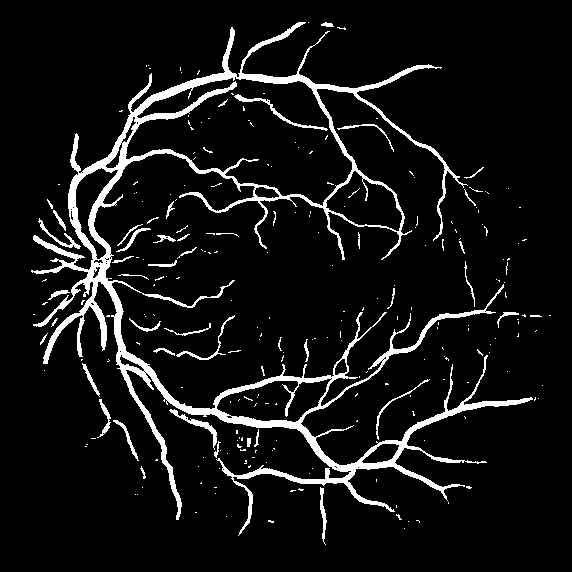

In [13]:
i = np.array(y_pred.reshape(-1, 572)*255, dtype=np.uint8)
IMG.fromarray(i)

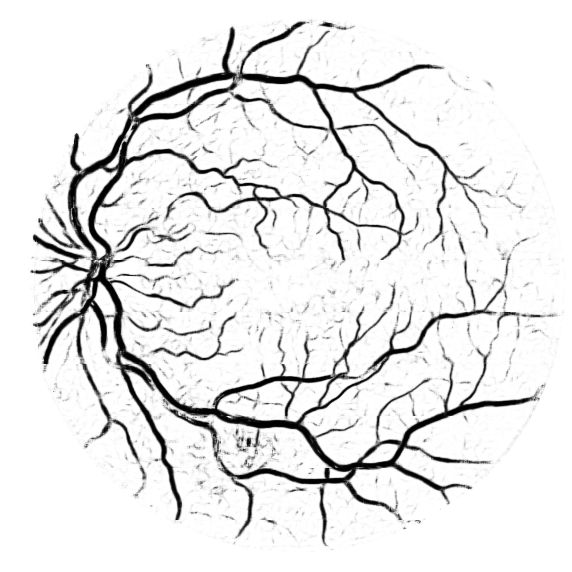

In [14]:
k = scores[:,1,:,:]
i = np.array(np.exp(k).reshape(-1, 572)*255, dtype=np.uint8)
IMG.fromarray(255-i)

In [24]:
params = {'sk_threshold': 50,
          'alpha': 5.0,
          'orig_contrib': 0.3,
          'seg_threshold': 30}

img_obj = SegmentedImage()

img_obj.load_file(data_dir=TestDirs['images'], file_name='03_test.tif')
img_obj.res['orig'] = img_obj.image_arr[:, :, 1]
img_obj.working_arr = 255-i

img_obj.load_mask(mask_dir=TestDirs['mask'], fget_mask=get_mask_file_test, erode=True)
img_obj.load_ground_truth(gt_dir=TestDirs['truth'], fget_ground_truth=get_ground_truth_file)

img_obj.generate_skeleton(threshold=params['sk_threshold'])
img_obj.generate_lattice_graph()

"generate_skeleton(__)" ... took 0.001 seconds
"generate_lattice_graph(__)" ... took 2.076 seconds


In [25]:
tester = AtureTest(out_dir='.')
tester.run(params=params, save_images=False, img_obj=img_obj)
img_obj.res['scores']

"run_segmentation(__)" ... took 69.756 seconds
Number of params combination tried: 1


{'Accuracy': 0.9583506528436598,
 'F1': 0.7870082370777911,
 'Precision': 0.8098822621115614,
 'Recall': 0.7653908126349072}

In [28]:
x = imgutil.get_rgb_scores(arr_2d=i, truth
                           =testset.images['0'].ground_truth)

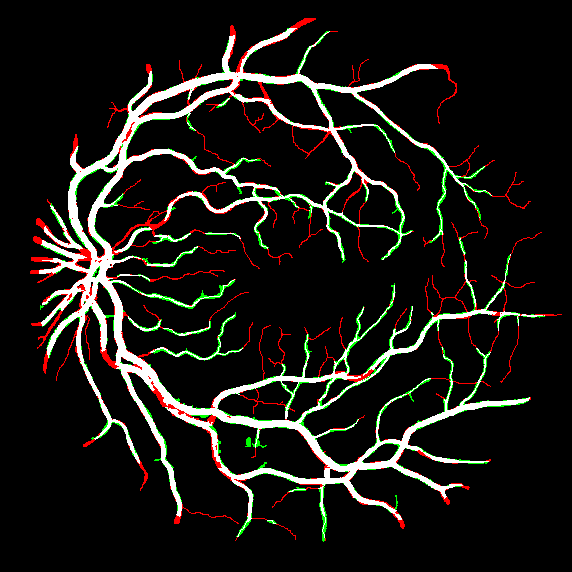

In [29]:
IMG.fromarray(imgutil.get_rgb_scores(img_obj.res['segmented'],img_obj.ground_truth))

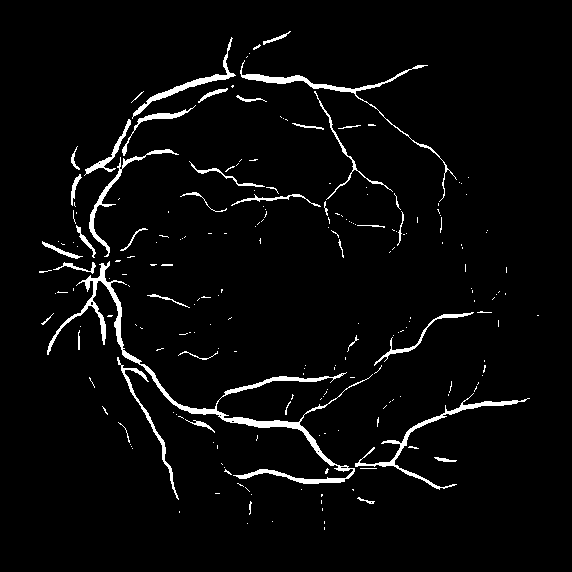

In [84]:
IMG.fromarray(img_obj.res['skeleton'])

In [53]:
for i in trainset:
    print(i[1].shape)
    break

torch.Size([52, 572])


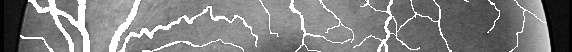

In [54]:
IMG.fromarray(np.array(i[0].squeeze()*255, dtype=np.uint8))

In [15]:
testset.file_names

['03_test.tif']

In [35]:
x = np.array([[0,1], [2,2]])

In [36]:
y = np.array([[0,0],[1,0]])

In [43]:
gg = img_obj.image_arr[:,:,1]
pp = img_obj.ground_truth
xx = np.bitwise_or(gg, pp)

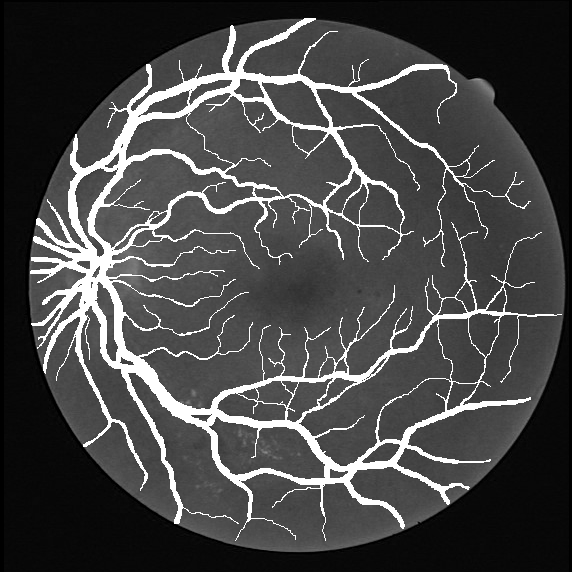

In [44]:
IMG.fromarray(xx)

In [55]:
x = np.array([0,1,2,3,4])

In [56]:
x[:2]

array([0, 1])